In [22]:
from utils import *

In [2]:
# Config plotting:
mpl.rcParams['ps.useafm'] = True                                                     
rc('font',**{'family':'sans-serif','sans-serif':['FreeSans']}) 
mpl.rcParams['pdf.fonttype'] = 3

### Read schedule

In [3]:
schedule = toast.schedule.GroundSchedule()

The schedule is created with ${\tt make\_schedule.sh}$ (see [Sec. 3](Sec3_Make_and_Analyze_schedule.ipynb)) or imported from [pwg-tds/pipe-s0002/v6/schedules/schedule_sat.txt](https://github.com/simonsobs/pwg-scripts/blob/24a8c8202e2f80fb9b5097ee0e2dcfe5c1c07114/pwg-tds/pipe-s0002/v6/schedules/schedule_sat.txt). 

In [4]:
#schedule.read('schedules/schedule_sat_10min.txt') # generated with make_schedule.sh
#schedule.read('schedule_sat_pipe-s0002-v6.txt') # Full SAT schedule for 1 yr (74 observations)
schedule.read('schedules/split_schedule/schedule040.txt') # Split schedule for 1 observation

TOAST INFO: Loading schedule from schedules/split_schedule/schedule040.txt
TOAST INFO: Loaded 1 scans from schedules/split_schedule/schedule040.txt totaling 19.9 minutes.


### Create focalplane

Here you can select the wafer slots, tube slots, and whether to thin the focal plane.

In [5]:
sample_rate = 10. #Hz

In [6]:
focalplane = sotoast.SOFocalplane(
        hwfile=None,
        telescope='SAT1',
        sample_rate=sample_rate * u.Hz,
        bands='SAT_f090',
        wafer_slots='w25', 
        tube_slots=None,
        thinfp=None,
        comm=None,
    )

### Create telescope from focalplane and schedule

In [7]:
telescope = toast.Telescope(name="SAT1", 
                            focalplane=focalplane, 
                            site=toast.GroundSite("Atacama", schedule.site_lat,
                                            schedule.site_lon, schedule.site_alt))

### Create data object

In [8]:
data = toast.Data()

In [9]:
# This should be empty 
data 

<Data with 0 Observations:
Metadata:
{}
>

### Simulate a generic ground-based telescope scanning

This simulates ground-based pointing in constant elevation scans for a telescope located at a particular site and using a pre-created schedule. Here we include HWP.

In [10]:
_, sim_gnd = apply_scanning(data, telescope, schedule)

The data object will now contain (empty) observation instances, which otherwise can be uploaded from: 
- the context.yaml file (output of toast3 simulation, v4)
- the h5 file (output of toast3 simulation, v6)

In [11]:
# TODO: make comparison with yaml and h5

In [12]:
# Inspect the data
data.info

<bound method Data.info of <Data with 1 Observations:
<Observation
  name = 'south-0-6'
  uid = '3433341973'  group has 1 processes
  telescope = <Telescope 'SAT1': uid = 4101420846, site = <GroundSite 'Atacama' : uid = 2329977149, lon = -67.786 deg, lat = -22.957999999999995 deg, alt = 5199.999999999236 m, weather = <SimWeather : 'atacama', year = 2025, month = 5, hour = 6, site UID = 2329977149, realization = 0, median = False)>, focalplane = <Focalplane: 860 detectors, sample_rate = 10.0 Hz, FOV = 35.6 deg, detectors = [w25_p000_SAT_f090_A .. w25_p431_SAT_f090_B]>>
  session = <Session 'south-0-6': uid = 3433341973, start = 2025-07-02 05:55:28+00:00, end = 2025-07-02 06:15:22.900000+00:00>
  scan_el = 55.0 deg
  scan_min_az = 1.8887987487087312 rad
  scan_max_az = 2.5998390215702853 rad
  scan_min_el = 0.9599310885968813 rad
  scan_max_el = 0.9599310885968813 rad
  11950 total samples (11950 local)
  shared:  <SharedDataManager
    times (column): shape=(11950,), dtype=float64
    p

In [13]:
# Extract single instances from data.obs list, e.g.
data.obs[0].telescope

<Telescope 'SAT1': uid = 4101420846, site = <GroundSite 'Atacama' : uid = 2329977149, lon = -67.786 deg, lat = -22.957999999999995 deg, alt = 5199.999999999236 m, weather = <SimWeather : 'atacama', year = 2025, month = 5, hour = 6, site UID = 2329977149, realization = 0, median = False)>, focalplane = <Focalplane: 860 detectors, sample_rate = 10.0 Hz, FOV = 35.6 deg, detectors = [w25_p000_SAT_f090_A .. w25_p431_SAT_f090_B]>>

In [14]:
# Signal should be empty, check first detector
data.obs[0].detdata['signal'][0]

array([0., 0., 0., ..., 0., 0., 0.])

In [15]:
# Explore the data manager instance
data.obs[0].shared

<SharedDataManager
    times (column): shape=(11950,), dtype=float64
    position (column): shape=(11950, 3), dtype=float64
    velocity (column): shape=(11950, 3), dtype=float64
    azimuth (column): shape=(11950,), dtype=float64
    elevation (column): shape=(11950,), dtype=float64
    boresight_azel (column): shape=(11950, 4), dtype=float64
    boresight_radec (column): shape=(11950, 4), dtype=float64
    hwp_angle (column): shape=(11950,), dtype=float64
    flags (column): shape=(11950,), dtype=uint8>

Text(0, 0.5, 'Elevation')

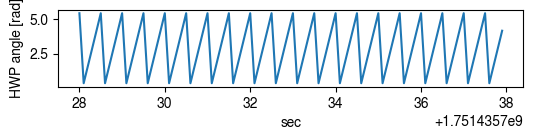

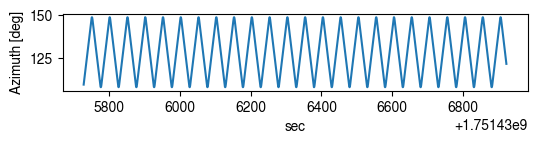

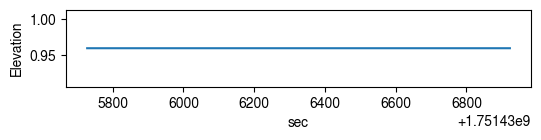

In [16]:
# Plot
fig,ax = plt.subplots(1,1,figsize=(6,1))
ax.plot(data.obs[0].shared['times'][:100], data.obs[0].shared['hwp_angle'][:100])
ax.set_xlabel('sec')
ax.set_ylabel('HWP angle [rad]')

fig,ax = plt.subplots(1,1,figsize=(6,1))
ax.plot(data.obs[0].shared['times'], np.array(data.obs[0].shared['azimuth'])*180./np.pi)
ax.set_xlabel('sec')
ax.set_ylabel('Azimuth [deg]')

fig,ax = plt.subplots(1,1,figsize=(6,1))
ax.plot(data.obs[0].shared['times'], data.obs[0].shared['elevation'])
ax.set_xlabel('sec')
ax.set_ylabel('Elevation')

### Pointing

In [17]:
data, det_pointing_radec = apply_det_pointing_radec(data, sim_gnd)
data, det_pointing_azel = apply_det_pointing_azel(data, sim_gnd)

Text(0, 0.5, 'azimuth [deg]')

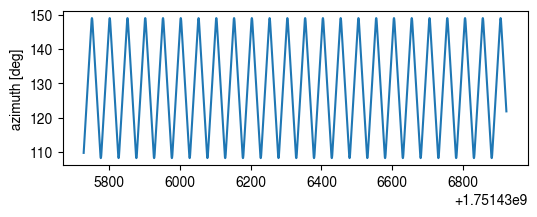

In [18]:
fig,ax = plt.subplots(1,1,figsize=(6,2))
ax.plot(data.obs[0].shared['times'], np.array(data.obs[0].shared['azimuth'])*180./np.pi)
ax.set_ylabel('azimuth [deg]')

### Pixel pointing healpix

In [19]:
nside_out = 512

In [25]:
data, pixels_radec = apply_pixels_radec(data, det_pointing_radec)

NameError: name 'apply_pixels_radec' is not defined

### Stokes Weights Radec

In [ ]:
data, weights_radec = apply_weights_radec(data, det_pointing_radec)

### Add signal

Here we use as input the HEALPix format map that was generated in [Sec. 2](Sec2_Sky_maps.ipynb) and scan it to a detector timestream.

In [ ]:
# Input map: signal only
file = 'input_maps/cmb_SAT_f090_ns512.fits'
IQUmap = hp.read_map(file, field=[0,1,2])

In [ ]:
npol = 3
for p in np.arange(npol):
    hp.mollview(IQU[p])

In [ ]:
data, scan_map = apply_scan_map(data, file, pixels_radec, weights_radec)

### Add noise

In [ ]:
data_after_noise_model, noise_model = apply_noise_model(data)

In [ ]:
data, sim_noise = apply_sim_noise(data)

### Save HDF5

In [ ]:
save_hdf5 = toast.ops.SaveHDF5(name="save_hdf5")
hdf5_path = os.path.join('outputs', "hdf5")
if not os.path.isdir(hdf5_path):
    os.makedirs(hdf5_path)
save_hdf5.volume = hdf5_path
save_hdf5.apply(data)